### Enviornment setup

conda activate torch_cuda121

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# For classification benchmark
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# For BERT
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, DataCollatorWithPadding
from torch.optim import AdamW
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

import warnings
warnings.filterwarnings("ignore", message="The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.")

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#root_path = '/content/drive/MyDrive/AC/07 NLP/Assignment/Assignment 2 Project'

root_path = ''

### System Parameters

In [3]:
verbose = 1
balanced_sample_enable = True
class_weight_enable    = True
benchmark_enable       = False
test_only              = False

num_epochs = 50
train_len  = 2000000

model_name = "roberta-base"

labels = ['hazard-category', 'product-category', 'product', 'hazard']
text_columns = ['title'] #,'text']  #  ['title', 'text']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load data

In [4]:
trainset = pd.read_csv(os.path.join(root_path,'Datasets','incidents_train.csv'), index_col=0)
trainset=trainset[:train_len]
validset = pd.read_csv(os.path.join(root_path,'Datasets','incidents_valid.csv'), index_col=0)
testset = pd.read_csv(os.path.join(root_path,'Datasets','incidents_test.csv'), index_col=0)

print('Column Name: ', list(trainset.columns))
print(f'Orignal Number of training samples: {len(trainset)} | validation samples: {len(validset)} | test samples: {len(testset)}')

Column Name:  ['year', 'month', 'day', 'country', 'title', 'text', 'hazard-category', 'product-category', 'hazard', 'product']
Orignal Number of training samples: 5082 | validation samples: 565 | test samples: 997


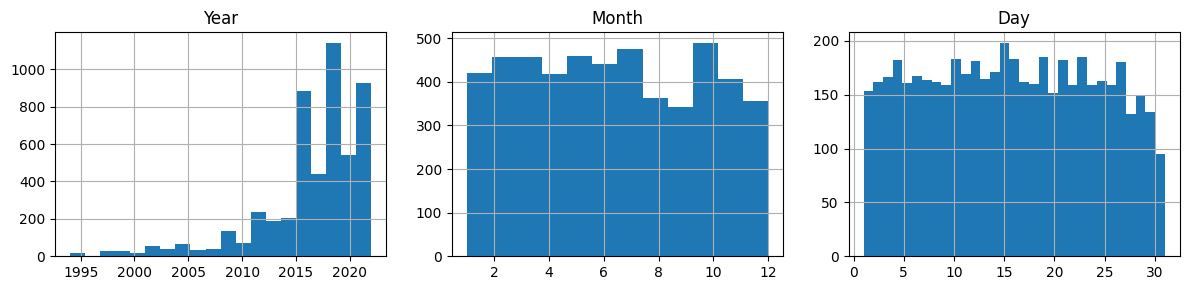

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
trainset['year'].hist(bins=20, ax=axes[0])
axes[0].set_title('Year')

trainset['month'].hist(bins=12, ax=axes[1])
axes[1].set_title('Month')

trainset['day'].hist(bins=31, ax=axes[2])
axes[2].set_title('Day')
plt.tight_layout()
plt.show()

In [6]:
def print_plot_column(incidents:pd.DataFrame, column:str, ax = None, num_examples:int=10):
    value_counts = incidents[column].value_counts()
    values = value_counts.index
    counts = value_counts.values

    num_values = len(counts)

    print(f'\nColumn "{column}" (n = {num_values:d}):')
    if num_values > num_examples:
        t_values = np.concatenate([values[:num_examples//2], values[-num_examples//2:]])
        t_counts = np.concatenate([counts[:num_examples//2], counts[-num_examples//2:]])
        for v, n in zip(t_values, t_counts):
            print(f'  {v}:{" "*(50-len(v))}{n:5d}')
    else:
        for v, n in zip(values, counts):
            print(f'  {v}:{" "*(50-len(v))}{n:5d}')

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if num_values > 20:
        num_values = 20
        values = np.array(list(values[:10]) + list(values[-10:]))
        counts = np.array(list(counts[:10]) + list(counts[-10:]))

    ax.bar(range(num_values), counts)
#    ax.set_ylabel('Count')

    if num_values <= 25:
        ax.set_xticks(range(num_values), values, rotation=90)
    else:
      ax.set_xticks([], [], rotation=90)


Column "hazard-category" (n = 10):
  allergens:                                          1854
  biological:                                         1741
  foreign bodies:                                      561
  fraud:                                               371
  chemical:                                            287
  other hazard:                                        134
  packaging defect:                                     54
  organoleptic aspects:                                 53
  food additives and flavourings:                       24
  migration:                                             3

Column "product-category" (n = 22):
  meat, egg and dairy products:                       1434
  cereals and bakery products:                         671
  fruits and vegetables:                               535
  prepared dishes and snacks:                          469
  seafood:                                             268
  food additives and flavourings:         

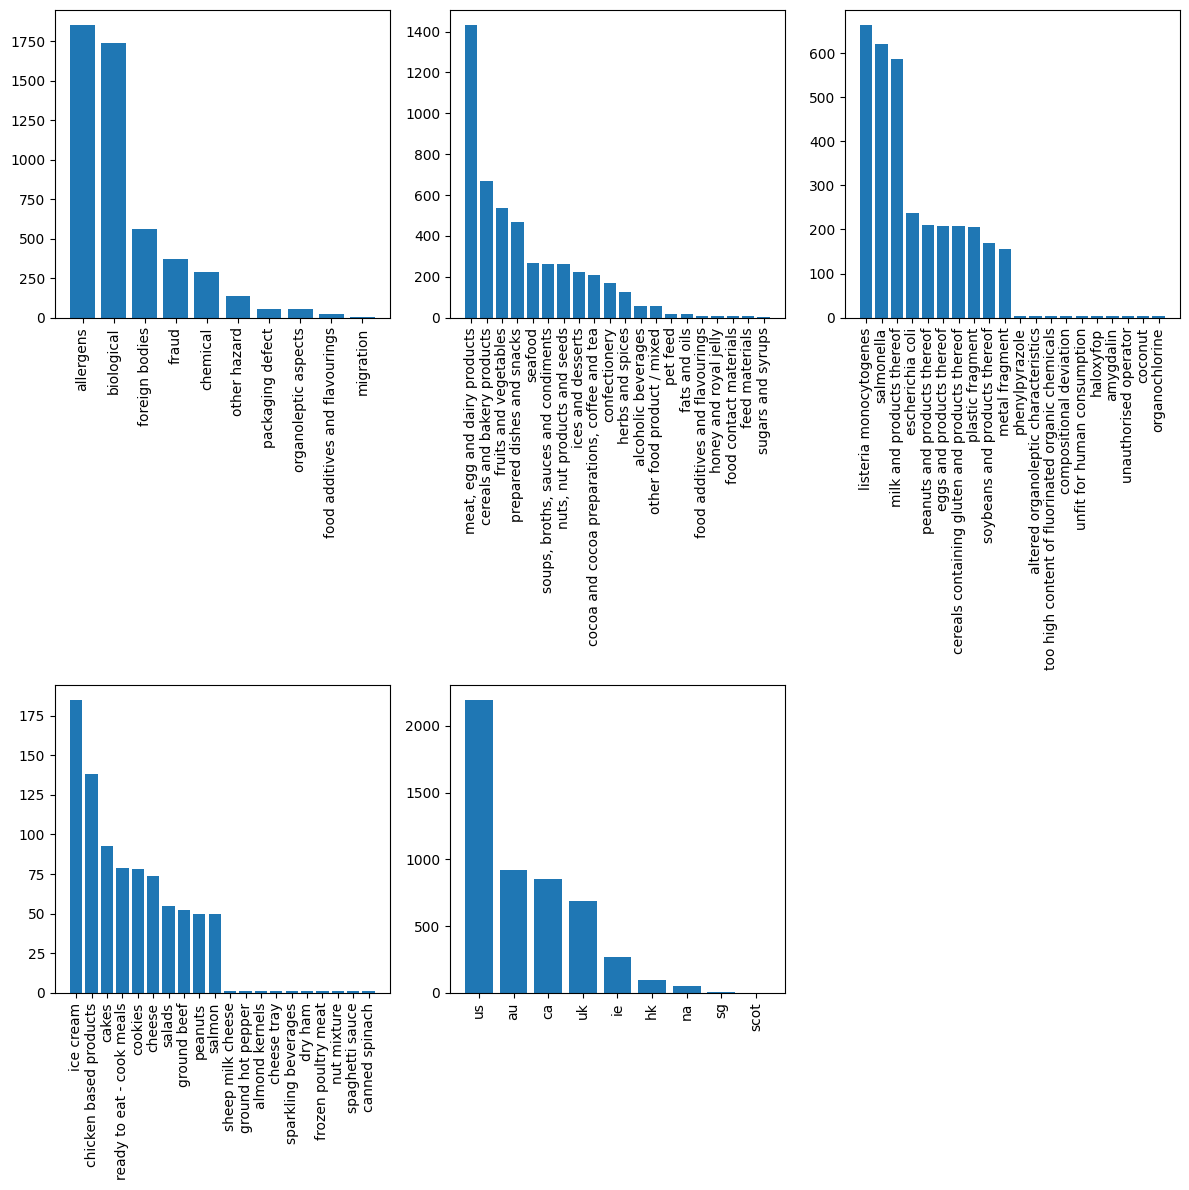

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))
print_plot_column(trainset, 'hazard-category',ax=axes[0,0])
print_plot_column(trainset, 'product-category',ax=axes[0,1])
print_plot_column(trainset, 'hazard',ax=axes[0,2])
print_plot_column(trainset, 'product',ax=axes[1,0])
print_plot_column(trainset, 'country',ax=axes[1,1])
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

### Preprocessing dataset

In [8]:
def combine_input_text(dataset, text_columns):
    """ text_columns to be tokenizeed, such as 'title' or ['title', 'text'] or
        {'columns': ['title', 'text'], 'separator': ' [SEP] '} or {'columns': ['title', 'text'], 'format': 'Title: {title} Content: {text}'}"""

        # Handle different text_columns input types
    if isinstance(text_columns, str):  # Single column
        dataset['combined_text'] = dataset[text_columns]

    elif isinstance(text_columns, list): # Multiple columns - simple concatenation
        dataset['combined_text'] = dataset[text_columns].astype(str).agg(' '.join, axis=1)

    elif isinstance(text_columns, dict):   # Advanced options with custom formatting
        columns = text_columns.get('columns', [])
        separator = text_columns.get('separator', ' ')
        format_template = text_columns.get('format', None)

        if format_template:  # Custom format like "Title: {title} Content: {text}""
            dataset['combined_text'] = dataset.apply(
                lambda row: format_template.format(**{col: row[col] for col in columns}),
                axis=1
            )
        else:  # Simple join with separator
            dataset['combined_text'] = dataset[columns].astype(str).agg(separator.join, axis=1)

    return dataset[['combined_text'] + labels]

In [9]:
# Remove all records whose value is not in trainset
# For each label column, create a boolean mask where values of validset are in trainset's column
mask = True
for label_column in labels:
    mask = mask & validset[label_column].isin(trainset[label_column].unique())
# Keep only rows where validset exist in df2 for atrainset columns
validset = validset[mask].reset_index(drop=True)

# Remove all records whose value is not in trainset
# For each label column, create a boolean mask where values of validset are in trainset's column
mask = True
for label_column in labels:
    mask = mask & testset[label_column].isin(trainset[label_column].unique())
# Keep only rows where testset exist in df2 for atrainset columns
testset = testset[mask].reset_index(drop=True)

trainset = combine_input_text(trainset, text_columns)
validset = combine_input_text(validset, text_columns)
testset  = combine_input_text(testset, text_columns)

# trainset.head(2)

print('Number of training samples: ', len(trainset), ' validation samples: ', len(validset), ' test samples: ', len(testset))
print('Column Name:\n', list(trainset.columns))
trainset.head(5)

word_counts = trainset['combined_text'].apply(lambda x: len(str(x).split()))
print(word_counts.describe())

Number of training samples:  5082  validation samples:  516  test samples:  913
Column Name:
 ['combined_text', 'hazard-category', 'product-category', 'product', 'hazard']
count    5082.000000
mean       13.282369
std         5.229355
min         1.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        44.000000
Name: combined_text, dtype: float64


### Performance metric function

In [10]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    # compute f1 for hazards:
    f1_hazards = f1_score(
      hazards_true,
      hazards_pred,
      average='macro'
    )

    # compute f1 for products:
    f1_products = f1_score(
      products_true[hazards_pred == hazards_true],
      products_pred[hazards_pred == hazards_true],
      average='macro'
    )

    return (f1_hazards + f1_products) / 2

#### Confusion Matrix

In [11]:
def plot_least_frequent_confusion_matrix(y_true, y_pred, label_count=8, title='Confusion Matrix'):
    # Plots a confusion matrix for the N least frequent true classes.

    # Compute label frequency
    label_freq = pd.Series(y_true).value_counts()

    # Handle case where label_count > number of labels
    num_labels = len(label_freq)
    if label_count > num_labels:
        label_count = num_labels

    # Get the least frequent class labels from true labels
    least_common_classes = label_freq.nsmallest(label_count).index.tolist()
    
    # Filter y_true and y_pred to include only the least common classes
    y_true_series = pd.Series(y_true)
    y_pred_series = pd.Series(y_pred)

    mask = y_true_series.isin(least_common_classes)
    y_true_filtered = y_true_series[mask]
    y_pred_filtered = y_pred_series[mask]
    
    #  Generate confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=least_common_classes)
    
    # Plot the matrix
    cm_df = pd.DataFrame(cm, index=least_common_classes, columns=least_common_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Benchmark

In [12]:
if benchmark_enable and (not test_only):
    text_clf_lr = Pipeline([
        ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(2,5), max_df=0.5, min_df=5)),
        ('clf', LogisticRegression(max_iter=1000)),
    ])

    test_true = {}
    test_pred = {}
    for label_column in labels:
        print(label_column.upper())

        label_encoder = LabelEncoder()
        label_encoder.fit(trainset[label_column])
        print(f'    Number of classes: {len(label_encoder.classes_)}')

        X_train = trainset['combined_text']
        y_train = label_encoder.transform(trainset[label_column])

        text_clf_lr.fit(X_train, y_train)

        # calculate scores using test dataset
        y_pred = text_clf_lr.predict(testset['combined_text'])

        test_true[label_column] = testset[label_column]
        test_pred[label_column] = label_encoder.inverse_transform(y_pred)

        accuracy = accuracy_score(test_true[label_column], test_pred[label_column])
        f1_marco = f1_score(test_true[label_column], test_pred[label_column], zero_division=0, average="macro")
        f1_mirco = f1_score(test_true[label_column], test_pred[label_column], zero_division=0, average="micro")

        plot_least_frequent_confusion_matrix(test_true[label_column], test_pred[label_column], label_count=10, title=label_column + ' Confusion Matrix')

        print(f'    Accuracy: {accuracy:.2f} | macro: {f1_marco:.2f} | micro: {f1_mirco:.2f}')

    ST1_score = compute_score(np.array(test_true['hazard-category']), np.array(test_true['product-category']),
                            np.array(test_pred['hazard-category']), np.array(test_pred['product-category']))
    ST2_score = compute_score(np.array(test_true['hazard']), np.array(test_true['product']),
                            np.array(test_pred['hazard']), np.array(test_pred['product']))

    print("")
    print(f"------ Benchmark Performance Results -------")
    print(f"Score Sub-Task 1: {ST1_score:.3f}")
    print(f"Score Sub-Task 2: {ST2_score:.3f}")

#### Generate dataloader

In [13]:
def tokenization(dataset, tokenizer, max_length=64):
    # Convert to HF Dataset

    hf_dataset = Dataset.from_pandas(dataset[['combined_text', 'label']])
    # print(hf_dataset)

    def tokenize_function(examples):
        return tokenizer(
            examples["combined_text"],
            truncation=True,
            padding=False,
            max_length=max_length
        )

    token_dataset = hf_dataset.map(tokenize_function, batched=True, desc=None)  # desc controls the progress display
    token_dataset = token_dataset.remove_columns(["combined_text"])
    # print(token_dataset)

    return token_dataset

def generate_dataloader(dataset, label_column, label_encoder, tokenizer, train_flag=False):

    # print(dataset.columns.tolist())
    dataset_copy = dataset.copy()
    dataset_copy['label'] = label_encoder.transform(dataset[label_column])
    # print(dataset_copy.columns.tolist())

    if 'token_dataset' in (locals() or globals()):
        del token_dataset

    token_dataset = tokenization(dataset_copy, tokenizer, max_length=512)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

    if train_flag == True:
        if balanced_sample_enable:
            def create_balanced_sampler(labels, num_classes):
                # Ensure weights cover all classes
                class_counts = np.bincount(labels, minlength=num_classes)

                # Calculate weights
                weights = len(labels) / (num_classes * class_counts)

                # Create sample weights for each label
                sample_weights = torch.tensor([weights[label] for label in labels])

                return WeightedRandomSampler(
                    weights=sample_weights,
                    num_samples=len(labels),
                    replacement=True
                )

            # When creating sampler
            num_classes = len(np.unique(token_dataset['label']))
            sampler = create_balanced_sampler(token_dataset['label'], num_classes)

            dataloader = DataLoader(token_dataset, sampler=sampler, batch_size=16, collate_fn=data_collator)
        else:
            dataloader = DataLoader(token_dataset, shuffle=True, batch_size=16, collate_fn=data_collator)

    else:
        dataloader = DataLoader(token_dataset, shuffle=False, batch_size=16, collate_fn=data_collator)

    return dataloader

#### Model evaluation function

In [14]:
def evaluate_model(model, valid_dataloader, label_encoder, verbose =4):
    # get the device (CPU or GPU) that the model is currently on.
    device = next(model.parameters()).device

    # set model to evaluation mode
    model.eval()

    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc=f"validation evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted',zero_division=0)

    # Convert predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(predictions)
    gold_labels = label_encoder.inverse_transform(true_labels)

    if verbose > 0:
        # Print results
        print(f'\tEvaluation Result -- Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')
    if verbose > 1:
        print("\tClassification Report:")
        print(classification_report(gold_labels, predicted_labels, zero_division=0))

    return true_labels, predictions

#### Function of model training with evaluation

In [15]:
def train_model(model, train_dataloader, label_encoder, num_epochs=3, learning_rate=2e-5,
                valid_dataloader=None, verbose=4):

    true_labels = None
    predictions = None

    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Add before training loop
    if class_weight_enable:
        data_label = train_dataloader.dataset['label']
        num_classes = len(label_encoder.classes_)
        class_weights = torch.zeros(num_classes, dtype=torch.float)
        unique_labels, counts = np.unique(data_label, return_counts=True)
        weights = len(data_label) / (num_classes * counts)
        class_weights[unique_labels] = torch.tensor(weights, dtype=torch.float)

     # Training loop
    for epoch in range(num_epochs):
        model.train()

        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss

            if class_weight_enable:
                # Modify loss calculation for imbalanced dataset
                criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
                loss = criterion(outputs.logits, labels)
            else:
                loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        if verbose > 0:
            print(f'\tEpoch {epoch+1}/{num_epochs}, Average Training Loss: {total_loss/len(train_dataloader):.4f}')

        if valid_dataloader is not None:
            # Evaluate performance using validset
            true_labels, predictions = evaluate_model(model, valid_dataloader, label_encoder, verbose)

    return true_labels, predictions

#### Training model

In [16]:
if not test_only:

    if model_name == "roberta-base":
        tokenizer = RobertaTokenizer.from_pretrained(model_name, disable_tqdm=True)
    else:
        raise ValueError(f"The {model_name} is not supported!")

    tokenizer_save_path = os.path.join(root_path, 'Models', f'{model_name}_tokenizer')
    tokenizer.save_pretrained(tokenizer_save_path)

    valid_true = {}
    valid_pred = {}
    for label_column in labels:
        print(f'\n{label_column.upper()}')

        label_encoder = LabelEncoder()
        label_encoder.fit(trainset[label_column])
        print(f'    Number of classes: {len(label_encoder.classes_)}')

        valid_dataloader = generate_dataloader(validset, label_column, label_encoder, tokenizer, train_flag=False)
        train_dataloader = generate_dataloader(trainset, label_column, label_encoder, tokenizer, train_flag=True)

        if model_name == "roberta-base":
            warnings.filterwarnings("ignore", message="Some weights of RobertaForSequenceClassification")
            # Dynamically create the model variable name
            model_variable_name = f"model_{label_column.replace('-', '_')}"
            exec(f"{model_variable_name} = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(trainset[label_column].unique()))")
        else:
            raise ValueError(f"The {model_name} is not supported!")

        # Get the dynamically created model
        model = eval(model_variable_name)

        if verbose > 2:
            print(model)

        valid_true[label_column], valid_pred[label_column] = train_model(model, train_dataloader, label_encoder,
                    num_epochs=num_epochs, learning_rate=2e-5, valid_dataloader=valid_dataloader, verbose=verbose)

        # Update the save path to reflect the new variable name and structure
        model_save_path = os.path.join(root_path, 'Models', f'{model_name}_{label_column}')
        model.save_pretrained(model_save_path)
        np.save(os.path.join(model_save_path, 'label_encoder.npy'), label_encoder.classes_)

        print('-'*50)

    ST1_score = compute_score(np.array(valid_true['hazard-category']), np.array(valid_true['product-category']),
                            np.array(valid_pred['hazard-category']), np.array(valid_pred['product-category']))
    ST2_score = compute_score(np.array(valid_true['hazard']), np.array(valid_true['product']),
                            np.array(valid_pred['hazard']), np.array(valid_pred['product']))
    print("")
    print(f"------ Validation Performance Results -------")
    print(f"Score Sub-Task 1: {ST1_score:.3f}")
    print(f"Score Sub-Task 2: {ST2_score:.3f}")



HAZARD-CATEGORY
    Number of classes: 10


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 318/318 [00:20<00:00, 15.78it/s]


	Epoch 1/50, Average Training Loss: 0.4666


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 79.99it/s]


	Evaluation Result -- Accuracy: 0.0484 | Precision: 0.0161 | Recall: 0.0484 | F1: 0.0188


Epoch 2/50: 100%|██████████| 318/318 [00:22<00:00, 14.28it/s]


	Epoch 2/50, Average Training Loss: 0.0933


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 93.53it/s]


	Evaluation Result -- Accuracy: 0.3140 | Precision: 0.4672 | Recall: 0.3140 | F1: 0.3115


Epoch 3/50: 100%|██████████| 318/318 [00:21<00:00, 15.02it/s]


	Epoch 3/50, Average Training Loss: 0.0633


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 84.44it/s]


	Evaluation Result -- Accuracy: 0.3953 | Precision: 0.4520 | Recall: 0.3953 | F1: 0.3735


Epoch 4/50: 100%|██████████| 318/318 [00:20<00:00, 15.72it/s]


	Epoch 4/50, Average Training Loss: 0.0439


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.25it/s]


	Evaluation Result -- Accuracy: 0.5213 | Precision: 0.8206 | Recall: 0.5213 | F1: 0.5426


Epoch 5/50: 100%|██████████| 318/318 [00:21<00:00, 14.86it/s]


	Epoch 5/50, Average Training Loss: 0.0305


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 64.89it/s]


	Evaluation Result -- Accuracy: 0.6260 | Precision: 0.8290 | Recall: 0.6260 | F1: 0.6613


Epoch 6/50: 100%|██████████| 318/318 [00:22<00:00, 14.43it/s]


	Epoch 6/50, Average Training Loss: 0.0229


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 68.82it/s]


	Evaluation Result -- Accuracy: 0.6744 | Precision: 0.8466 | Recall: 0.6744 | F1: 0.7179


Epoch 7/50: 100%|██████████| 318/318 [00:22<00:00, 14.42it/s]


	Epoch 7/50, Average Training Loss: 0.0362


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 54.62it/s]


	Evaluation Result -- Accuracy: 0.6686 | Precision: 0.8326 | Recall: 0.6686 | F1: 0.7098


Epoch 8/50: 100%|██████████| 318/318 [00:24<00:00, 13.03it/s]


	Epoch 8/50, Average Training Loss: 0.0254


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 67.21it/s]


	Evaluation Result -- Accuracy: 0.6570 | Precision: 0.8298 | Recall: 0.6570 | F1: 0.6856


Epoch 9/50: 100%|██████████| 318/318 [00:25<00:00, 12.69it/s]


	Epoch 9/50, Average Training Loss: 0.0316


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 39.81it/s]


	Evaluation Result -- Accuracy: 0.6240 | Precision: 0.8273 | Recall: 0.6240 | F1: 0.6564


Epoch 10/50: 100%|██████████| 318/318 [00:28<00:00, 11.35it/s]


	Epoch 10/50, Average Training Loss: 0.0135


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.85it/s]


	Evaluation Result -- Accuracy: 0.6395 | Precision: 0.8149 | Recall: 0.6395 | F1: 0.6734


Epoch 11/50: 100%|██████████| 318/318 [00:32<00:00,  9.85it/s]


	Epoch 11/50, Average Training Loss: 0.0209


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 41.46it/s]


	Evaluation Result -- Accuracy: 0.7054 | Precision: 0.8212 | Recall: 0.7054 | F1: 0.7316


Epoch 12/50: 100%|██████████| 318/318 [00:26<00:00, 12.22it/s]


	Epoch 12/50, Average Training Loss: 0.0112


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 43.65it/s]


	Evaluation Result -- Accuracy: 0.6512 | Precision: 0.8262 | Recall: 0.6512 | F1: 0.6771


Epoch 13/50: 100%|██████████| 318/318 [00:26<00:00, 12.16it/s]


	Epoch 13/50, Average Training Loss: 0.0081


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 42.15it/s]


	Evaluation Result -- Accuracy: 0.6802 | Precision: 0.8309 | Recall: 0.6802 | F1: 0.7028


Epoch 14/50: 100%|██████████| 318/318 [00:31<00:00, 10.12it/s]


	Epoch 14/50, Average Training Loss: 0.0170


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.13it/s]


	Evaluation Result -- Accuracy: 0.6686 | Precision: 0.8300 | Recall: 0.6686 | F1: 0.7014


Epoch 15/50: 100%|██████████| 318/318 [00:19<00:00, 16.66it/s]


	Epoch 15/50, Average Training Loss: 0.0506


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.18it/s]


	Evaluation Result -- Accuracy: 0.5872 | Precision: 0.8194 | Recall: 0.5872 | F1: 0.6314


Epoch 16/50: 100%|██████████| 318/318 [00:17<00:00, 17.76it/s]


	Epoch 16/50, Average Training Loss: 0.0125


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.65it/s]


	Evaluation Result -- Accuracy: 0.6783 | Precision: 0.8313 | Recall: 0.6783 | F1: 0.7068


Epoch 17/50: 100%|██████████| 318/318 [00:18<00:00, 17.28it/s]


	Epoch 17/50, Average Training Loss: 0.0103


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.52it/s]


	Evaluation Result -- Accuracy: 0.7074 | Precision: 0.8216 | Recall: 0.7074 | F1: 0.7337


Epoch 18/50: 100%|██████████| 318/318 [00:18<00:00, 17.39it/s]


	Epoch 18/50, Average Training Loss: 0.0242


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.44it/s]


	Evaluation Result -- Accuracy: 0.6609 | Precision: 0.8146 | Recall: 0.6609 | F1: 0.6891


Epoch 19/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 19/50, Average Training Loss: 0.0168


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.55it/s]


	Evaluation Result -- Accuracy: 0.6977 | Precision: 0.8230 | Recall: 0.6977 | F1: 0.7254


Epoch 20/50: 100%|██████████| 318/318 [00:18<00:00, 17.22it/s]


	Epoch 20/50, Average Training Loss: 0.0101


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.43it/s]


	Evaluation Result -- Accuracy: 0.7364 | Precision: 0.8245 | Recall: 0.7364 | F1: 0.7573


Epoch 21/50: 100%|██████████| 318/318 [00:18<00:00, 17.23it/s]


	Epoch 21/50, Average Training Loss: 0.0076


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.35it/s]


	Evaluation Result -- Accuracy: 0.7752 | Precision: 0.8314 | Recall: 0.7752 | F1: 0.7909


Epoch 22/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 22/50, Average Training Loss: 0.0085


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.36it/s]


	Evaluation Result -- Accuracy: 0.7384 | Precision: 0.8206 | Recall: 0.7384 | F1: 0.7578


Epoch 23/50: 100%|██████████| 318/318 [00:17<00:00, 17.81it/s]


	Epoch 23/50, Average Training Loss: 0.0084


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.00it/s]


	Evaluation Result -- Accuracy: 0.7287 | Precision: 0.8277 | Recall: 0.7287 | F1: 0.7510


Epoch 24/50: 100%|██████████| 318/318 [00:18<00:00, 17.15it/s]


	Epoch 24/50, Average Training Loss: 0.0073


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.89it/s]


	Evaluation Result -- Accuracy: 0.7519 | Precision: 0.8266 | Recall: 0.7519 | F1: 0.7699


Epoch 25/50: 100%|██████████| 318/318 [00:18<00:00, 17.22it/s]


	Epoch 25/50, Average Training Loss: 0.0080


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.75it/s]


	Evaluation Result -- Accuracy: 0.6996 | Precision: 0.8203 | Recall: 0.6996 | F1: 0.7226


Epoch 26/50: 100%|██████████| 318/318 [00:17<00:00, 18.17it/s]


	Epoch 26/50, Average Training Loss: 0.0061


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.46it/s]


	Evaluation Result -- Accuracy: 0.7403 | Precision: 0.7999 | Recall: 0.7403 | F1: 0.7553


Epoch 27/50: 100%|██████████| 318/318 [00:17<00:00, 18.01it/s]


	Epoch 27/50, Average Training Loss: 0.0067


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.26it/s]


	Evaluation Result -- Accuracy: 0.7054 | Precision: 0.8080 | Recall: 0.7054 | F1: 0.7309


Epoch 28/50: 100%|██████████| 318/318 [00:18<00:00, 17.26it/s]


	Epoch 28/50, Average Training Loss: 0.0076


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.27it/s]


	Evaluation Result -- Accuracy: 0.6589 | Precision: 0.8236 | Recall: 0.6589 | F1: 0.6895


Epoch 29/50: 100%|██████████| 318/318 [00:18<00:00, 17.14it/s]


	Epoch 29/50, Average Training Loss: 0.0070


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.37it/s]


	Evaluation Result -- Accuracy: 0.7171 | Precision: 0.8070 | Recall: 0.7171 | F1: 0.7381


Epoch 30/50: 100%|██████████| 318/318 [00:18<00:00, 17.38it/s]


	Epoch 30/50, Average Training Loss: 0.0080


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.49it/s]


	Evaluation Result -- Accuracy: 0.6919 | Precision: 0.8279 | Recall: 0.6919 | F1: 0.7186


Epoch 31/50: 100%|██████████| 318/318 [00:18<00:00, 17.17it/s]


	Epoch 31/50, Average Training Loss: 0.0063


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.25it/s]


	Evaluation Result -- Accuracy: 0.7326 | Precision: 0.8247 | Recall: 0.7326 | F1: 0.7552


Epoch 32/50: 100%|██████████| 318/318 [00:18<00:00, 17.14it/s]


	Epoch 32/50, Average Training Loss: 0.0121


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.28it/s]


	Evaluation Result -- Accuracy: 0.6996 | Precision: 0.8131 | Recall: 0.6996 | F1: 0.7247


Epoch 33/50: 100%|██████████| 318/318 [00:18<00:00, 17.23it/s]


	Epoch 33/50, Average Training Loss: 0.0293


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.06it/s]


	Evaluation Result -- Accuracy: 0.6550 | Precision: 0.8164 | Recall: 0.6550 | F1: 0.6837


Epoch 34/50: 100%|██████████| 318/318 [00:18<00:00, 17.16it/s]


	Epoch 34/50, Average Training Loss: 0.0078


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.48it/s]


	Evaluation Result -- Accuracy: 0.6744 | Precision: 0.8012 | Recall: 0.6744 | F1: 0.7004


Epoch 35/50: 100%|██████████| 318/318 [00:18<00:00, 17.20it/s]


	Epoch 35/50, Average Training Loss: 0.0092


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.33it/s]


	Evaluation Result -- Accuracy: 0.7054 | Precision: 0.7985 | Recall: 0.7054 | F1: 0.7272


Epoch 36/50: 100%|██████████| 318/318 [00:18<00:00, 17.22it/s]


	Epoch 36/50, Average Training Loss: 0.0088


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.53it/s]


	Evaluation Result -- Accuracy: 0.6143 | Precision: 0.7847 | Recall: 0.6143 | F1: 0.6511


Epoch 37/50: 100%|██████████| 318/318 [00:18<00:00, 17.26it/s]


	Epoch 37/50, Average Training Loss: 0.0042


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.46it/s]


	Evaluation Result -- Accuracy: 0.6880 | Precision: 0.7996 | Recall: 0.6880 | F1: 0.7084


Epoch 38/50: 100%|██████████| 318/318 [00:18<00:00, 17.15it/s]


	Epoch 38/50, Average Training Loss: 0.0043


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.48it/s]


	Evaluation Result -- Accuracy: 0.7403 | Precision: 0.8109 | Recall: 0.7403 | F1: 0.7565


Epoch 39/50: 100%|██████████| 318/318 [00:18<00:00, 17.28it/s]


	Epoch 39/50, Average Training Loss: 0.0032


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.47it/s]


	Evaluation Result -- Accuracy: 0.7326 | Precision: 0.7959 | Recall: 0.7326 | F1: 0.7474


Epoch 40/50: 100%|██████████| 318/318 [00:18<00:00, 17.28it/s]


	Epoch 40/50, Average Training Loss: 0.0040


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.74it/s]


	Evaluation Result -- Accuracy: 0.7132 | Precision: 0.8068 | Recall: 0.7132 | F1: 0.7302


Epoch 41/50: 100%|██████████| 318/318 [00:18<00:00, 17.23it/s]


	Epoch 41/50, Average Training Loss: 0.0150


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.53it/s]


	Evaluation Result -- Accuracy: 0.7074 | Precision: 0.8178 | Recall: 0.7074 | F1: 0.7301


Epoch 42/50: 100%|██████████| 318/318 [00:18<00:00, 17.22it/s]


	Epoch 42/50, Average Training Loss: 0.0134


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.49it/s]


	Evaluation Result -- Accuracy: 0.7364 | Precision: 0.8205 | Recall: 0.7364 | F1: 0.7577


Epoch 43/50: 100%|██████████| 318/318 [00:18<00:00, 17.08it/s]


	Epoch 43/50, Average Training Loss: 0.0047


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.59it/s]


	Evaluation Result -- Accuracy: 0.7287 | Precision: 0.7850 | Recall: 0.7287 | F1: 0.7444


Epoch 44/50: 100%|██████████| 318/318 [00:18<00:00, 17.15it/s]


	Epoch 44/50, Average Training Loss: 0.0054


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.58it/s]


	Evaluation Result -- Accuracy: 0.7539 | Precision: 0.8140 | Recall: 0.7539 | F1: 0.7696


Epoch 45/50: 100%|██████████| 318/318 [00:18<00:00, 17.22it/s]


	Epoch 45/50, Average Training Loss: 0.0039


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.42it/s]


	Evaluation Result -- Accuracy: 0.8062 | Precision: 0.8391 | Recall: 0.8062 | F1: 0.8147


Epoch 46/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 46/50, Average Training Loss: 0.0041


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.36it/s]


	Evaluation Result -- Accuracy: 0.7539 | Precision: 0.8213 | Recall: 0.7539 | F1: 0.7694


Epoch 47/50: 100%|██████████| 318/318 [00:18<00:00, 17.37it/s]


	Epoch 47/50, Average Training Loss: 0.0036


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.26it/s]


	Evaluation Result -- Accuracy: 0.7984 | Precision: 0.8234 | Recall: 0.7984 | F1: 0.8054


Epoch 48/50: 100%|██████████| 318/318 [00:18<00:00, 17.33it/s]


	Epoch 48/50, Average Training Loss: 0.0033


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.58it/s]


	Evaluation Result -- Accuracy: 0.7791 | Precision: 0.8367 | Recall: 0.7791 | F1: 0.7986


Epoch 49/50: 100%|██████████| 318/318 [00:18<00:00, 17.22it/s]


	Epoch 49/50, Average Training Loss: 0.0089


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 91.28it/s]


	Evaluation Result -- Accuracy: 0.7578 | Precision: 0.8161 | Recall: 0.7578 | F1: 0.7714


Epoch 50/50: 100%|██████████| 318/318 [00:18<00:00, 17.39it/s]


	Epoch 50/50, Average Training Loss: 0.0040


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.37it/s]


	Evaluation Result -- Accuracy: 0.7926 | Precision: 0.8286 | Recall: 0.7926 | F1: 0.8032
--------------------------------------------------

PRODUCT-CATEGORY
    Number of classes: 22


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 318/318 [00:18<00:00, 16.84it/s]


	Epoch 1/50, Average Training Loss: 0.9180


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.29it/s]


	Evaluation Result -- Accuracy: 0.0795 | Precision: 0.1256 | Recall: 0.0795 | F1: 0.0633


Epoch 2/50: 100%|██████████| 318/318 [00:19<00:00, 16.72it/s]


	Epoch 2/50, Average Training Loss: 0.1948


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.48it/s]


	Evaluation Result -- Accuracy: 0.2500 | Precision: 0.2165 | Recall: 0.2500 | F1: 0.1791


Epoch 3/50: 100%|██████████| 318/318 [00:18<00:00, 16.82it/s]


	Epoch 3/50, Average Training Loss: 0.1196


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.64it/s]


	Evaluation Result -- Accuracy: 0.3159 | Precision: 0.1781 | Recall: 0.3159 | F1: 0.2117


Epoch 4/50: 100%|██████████| 318/318 [00:19<00:00, 16.74it/s]


	Epoch 4/50, Average Training Loss: 0.0796


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.22it/s]


	Evaluation Result -- Accuracy: 0.3469 | Precision: 0.3076 | Recall: 0.3469 | F1: 0.2706


Epoch 5/50: 100%|██████████| 318/318 [00:18<00:00, 16.78it/s]


	Epoch 5/50, Average Training Loss: 0.0644


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.12it/s]


	Evaluation Result -- Accuracy: 0.4516 | Precision: 0.4391 | Recall: 0.4516 | F1: 0.3766


Epoch 6/50: 100%|██████████| 318/318 [00:18<00:00, 16.94it/s]


	Epoch 6/50, Average Training Loss: 0.0519


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 95.99it/s]


	Evaluation Result -- Accuracy: 0.4089 | Precision: 0.3824 | Recall: 0.4089 | F1: 0.3406


Epoch 7/50: 100%|██████████| 318/318 [00:18<00:00, 16.83it/s]


	Epoch 7/50, Average Training Loss: 0.0402


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 95.90it/s]


	Evaluation Result -- Accuracy: 0.5116 | Precision: 0.7182 | Recall: 0.5116 | F1: 0.4604


Epoch 8/50: 100%|██████████| 318/318 [00:18<00:00, 16.75it/s]


	Epoch 8/50, Average Training Loss: 0.0757


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.23it/s]


	Evaluation Result -- Accuracy: 0.4612 | Precision: 0.4176 | Recall: 0.4612 | F1: 0.4006


Epoch 9/50: 100%|██████████| 318/318 [00:18<00:00, 16.79it/s]


	Epoch 9/50, Average Training Loss: 0.0319


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.31it/s]


	Evaluation Result -- Accuracy: 0.5194 | Precision: 0.7235 | Recall: 0.5194 | F1: 0.4882


Epoch 10/50: 100%|██████████| 318/318 [00:18<00:00, 16.84it/s]


	Epoch 10/50, Average Training Loss: 0.0407


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.39it/s]


	Evaluation Result -- Accuracy: 0.5329 | Precision: 0.7298 | Recall: 0.5329 | F1: 0.5055


Epoch 11/50: 100%|██████████| 318/318 [00:18<00:00, 16.91it/s]


	Epoch 11/50, Average Training Loss: 0.0360


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.07it/s]


	Evaluation Result -- Accuracy: 0.4961 | Precision: 0.7101 | Recall: 0.4961 | F1: 0.4501


Epoch 12/50: 100%|██████████| 318/318 [00:18<00:00, 16.81it/s]


	Epoch 12/50, Average Training Loss: 0.0248


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.06it/s]


	Evaluation Result -- Accuracy: 0.5543 | Precision: 0.7121 | Recall: 0.5543 | F1: 0.5396


Epoch 13/50: 100%|██████████| 318/318 [00:18<00:00, 16.82it/s]


	Epoch 13/50, Average Training Loss: 0.0201


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.31it/s]


	Evaluation Result -- Accuracy: 0.6124 | Precision: 0.7235 | Recall: 0.6124 | F1: 0.6142


Epoch 14/50: 100%|██████████| 318/318 [00:18<00:00, 16.96it/s]


	Epoch 14/50, Average Training Loss: 0.0217


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.21it/s]


	Evaluation Result -- Accuracy: 0.5950 | Precision: 0.7323 | Recall: 0.5950 | F1: 0.5876


Epoch 15/50: 100%|██████████| 318/318 [00:18<00:00, 16.80it/s]


	Epoch 15/50, Average Training Loss: 0.0180


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.25it/s]


	Evaluation Result -- Accuracy: 0.6880 | Precision: 0.7516 | Recall: 0.6880 | F1: 0.6962


Epoch 16/50: 100%|██████████| 318/318 [00:18<00:00, 16.80it/s]


	Epoch 16/50, Average Training Loss: 0.0152


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.03it/s]


	Evaluation Result -- Accuracy: 0.6202 | Precision: 0.7683 | Recall: 0.6202 | F1: 0.6291


Epoch 17/50: 100%|██████████| 318/318 [00:18<00:00, 16.80it/s]


	Epoch 17/50, Average Training Loss: 0.0153


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.23it/s]


	Evaluation Result -- Accuracy: 0.6027 | Precision: 0.7562 | Recall: 0.6027 | F1: 0.5958


Epoch 18/50: 100%|██████████| 318/318 [00:18<00:00, 16.78it/s]


	Epoch 18/50, Average Training Loss: 0.0171


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.30it/s]


	Evaluation Result -- Accuracy: 0.6395 | Precision: 0.7357 | Recall: 0.6395 | F1: 0.6547


Epoch 19/50: 100%|██████████| 318/318 [00:18<00:00, 16.79it/s]


	Epoch 19/50, Average Training Loss: 0.0602


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.21it/s]


	Evaluation Result -- Accuracy: 0.5601 | Precision: 0.7423 | Recall: 0.5601 | F1: 0.5471


Epoch 20/50: 100%|██████████| 318/318 [00:18<00:00, 16.79it/s]


	Epoch 20/50, Average Training Loss: 0.0214


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.07it/s]


	Evaluation Result -- Accuracy: 0.6085 | Precision: 0.7583 | Recall: 0.6085 | F1: 0.6067


Epoch 21/50: 100%|██████████| 318/318 [00:19<00:00, 16.72it/s]


	Epoch 21/50, Average Training Loss: 0.0136


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.22it/s]


	Evaluation Result -- Accuracy: 0.6996 | Precision: 0.7632 | Recall: 0.6996 | F1: 0.7110


Epoch 22/50: 100%|██████████| 318/318 [00:19<00:00, 16.68it/s]


	Epoch 22/50, Average Training Loss: 0.0113


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.15it/s]


	Evaluation Result -- Accuracy: 0.6899 | Precision: 0.7767 | Recall: 0.6899 | F1: 0.7013


Epoch 23/50: 100%|██████████| 318/318 [00:18<00:00, 16.80it/s]


	Epoch 23/50, Average Training Loss: 0.0131


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.28it/s]


	Evaluation Result -- Accuracy: 0.6667 | Precision: 0.7541 | Recall: 0.6667 | F1: 0.6743


Epoch 24/50: 100%|██████████| 318/318 [00:18<00:00, 16.85it/s]


	Epoch 24/50, Average Training Loss: 0.0107


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.42it/s]


	Evaluation Result -- Accuracy: 0.7112 | Precision: 0.7924 | Recall: 0.7112 | F1: 0.7263


Epoch 25/50: 100%|██████████| 318/318 [00:18<00:00, 16.79it/s]


	Epoch 25/50, Average Training Loss: 0.0103


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.38it/s]


	Evaluation Result -- Accuracy: 0.7171 | Precision: 0.7684 | Recall: 0.7171 | F1: 0.7249


Epoch 26/50: 100%|██████████| 318/318 [00:18<00:00, 16.75it/s]


	Epoch 26/50, Average Training Loss: 0.0100


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.32it/s]


	Evaluation Result -- Accuracy: 0.6512 | Precision: 0.7638 | Recall: 0.6512 | F1: 0.6600


Epoch 27/50: 100%|██████████| 318/318 [00:19<00:00, 16.61it/s]


	Epoch 27/50, Average Training Loss: 0.0084


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.18it/s]


	Evaluation Result -- Accuracy: 0.6647 | Precision: 0.7692 | Recall: 0.6647 | F1: 0.6776


Epoch 28/50: 100%|██████████| 318/318 [00:18<00:00, 16.90it/s]


	Epoch 28/50, Average Training Loss: 0.0153


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.44it/s]


	Evaluation Result -- Accuracy: 0.6570 | Precision: 0.7615 | Recall: 0.6570 | F1: 0.6720


Epoch 29/50: 100%|██████████| 318/318 [00:18<00:00, 16.76it/s]


	Epoch 29/50, Average Training Loss: 0.0120


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.27it/s]


	Evaluation Result -- Accuracy: 0.6938 | Precision: 0.7944 | Recall: 0.6938 | F1: 0.7091


Epoch 30/50: 100%|██████████| 318/318 [00:18<00:00, 16.76it/s]


	Epoch 30/50, Average Training Loss: 0.0081


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.18it/s]


	Evaluation Result -- Accuracy: 0.7093 | Precision: 0.7762 | Recall: 0.7093 | F1: 0.7229


Epoch 31/50: 100%|██████████| 318/318 [00:18<00:00, 16.91it/s]


	Epoch 31/50, Average Training Loss: 0.0174


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.38it/s]


	Evaluation Result -- Accuracy: 0.5213 | Precision: 0.7720 | Recall: 0.5213 | F1: 0.5164


Epoch 32/50: 100%|██████████| 318/318 [00:18<00:00, 16.88it/s]


	Epoch 32/50, Average Training Loss: 0.0186


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.33it/s]


	Evaluation Result -- Accuracy: 0.7112 | Precision: 0.7630 | Recall: 0.7112 | F1: 0.7198


Epoch 33/50: 100%|██████████| 318/318 [00:18<00:00, 16.87it/s]


	Epoch 33/50, Average Training Loss: 0.0104


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.27it/s]


	Evaluation Result -- Accuracy: 0.6783 | Precision: 0.7768 | Recall: 0.6783 | F1: 0.6841


Epoch 34/50: 100%|██████████| 318/318 [00:18<00:00, 16.87it/s]


	Epoch 34/50, Average Training Loss: 0.0082


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.39it/s]


	Evaluation Result -- Accuracy: 0.7035 | Precision: 0.7805 | Recall: 0.7035 | F1: 0.7163


Epoch 35/50: 100%|██████████| 318/318 [00:18<00:00, 16.79it/s]


	Epoch 35/50, Average Training Loss: 0.0090


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.54it/s]


	Evaluation Result -- Accuracy: 0.6996 | Precision: 0.7591 | Recall: 0.6996 | F1: 0.7093


Epoch 36/50: 100%|██████████| 318/318 [00:18<00:00, 16.83it/s]


	Epoch 36/50, Average Training Loss: 0.0104


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 93.35it/s]


	Evaluation Result -- Accuracy: 0.6919 | Precision: 0.7872 | Recall: 0.6919 | F1: 0.7051


Epoch 37/50: 100%|██████████| 318/318 [00:19<00:00, 16.71it/s]


	Epoch 37/50, Average Training Loss: 0.0059


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 95.95it/s]


	Evaluation Result -- Accuracy: 0.6919 | Precision: 0.7478 | Recall: 0.6919 | F1: 0.7016


Epoch 38/50: 100%|██████████| 318/318 [00:18<00:00, 16.74it/s]


	Epoch 38/50, Average Training Loss: 0.0273


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.06it/s]


	Evaluation Result -- Accuracy: 0.6085 | Precision: 0.7221 | Recall: 0.6085 | F1: 0.6151


Epoch 39/50: 100%|██████████| 318/318 [00:18<00:00, 16.82it/s]


	Epoch 39/50, Average Training Loss: 0.0311


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.23it/s]


	Evaluation Result -- Accuracy: 0.6337 | Precision: 0.7574 | Recall: 0.6337 | F1: 0.6448


Epoch 40/50: 100%|██████████| 318/318 [00:18<00:00, 16.78it/s]


	Epoch 40/50, Average Training Loss: 0.0100


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.10it/s]


	Evaluation Result -- Accuracy: 0.6919 | Precision: 0.7500 | Recall: 0.6919 | F1: 0.7025


Epoch 41/50: 100%|██████████| 318/318 [00:18<00:00, 16.75it/s]


	Epoch 41/50, Average Training Loss: 0.0069


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.22it/s]


	Evaluation Result -- Accuracy: 0.7132 | Precision: 0.7608 | Recall: 0.7132 | F1: 0.7238


Epoch 42/50: 100%|██████████| 318/318 [00:19<00:00, 16.68it/s]


	Epoch 42/50, Average Training Loss: 0.0078


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 95.79it/s]


	Evaluation Result -- Accuracy: 0.6744 | Precision: 0.7772 | Recall: 0.6744 | F1: 0.6871


Epoch 43/50: 100%|██████████| 318/318 [00:19<00:00, 16.73it/s]


	Epoch 43/50, Average Training Loss: 0.0052


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.10it/s]


	Evaluation Result -- Accuracy: 0.7248 | Precision: 0.7753 | Recall: 0.7248 | F1: 0.7346


Epoch 44/50: 100%|██████████| 318/318 [00:19<00:00, 16.72it/s]


	Epoch 44/50, Average Training Loss: 0.0054


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.12it/s]


	Evaluation Result -- Accuracy: 0.7209 | Precision: 0.7767 | Recall: 0.7209 | F1: 0.7323


Epoch 45/50: 100%|██████████| 318/318 [00:18<00:00, 16.86it/s]


	Epoch 45/50, Average Training Loss: 0.0055


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.10it/s]


	Evaluation Result -- Accuracy: 0.7074 | Precision: 0.7611 | Recall: 0.7074 | F1: 0.7193


Epoch 46/50: 100%|██████████| 318/318 [00:19<00:00, 16.71it/s]


	Epoch 46/50, Average Training Loss: 0.0043


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.37it/s]


	Evaluation Result -- Accuracy: 0.7267 | Precision: 0.7762 | Recall: 0.7267 | F1: 0.7391


Epoch 47/50: 100%|██████████| 318/318 [00:18<00:00, 16.92it/s]


	Epoch 47/50, Average Training Loss: 0.0047


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.31it/s]


	Evaluation Result -- Accuracy: 0.6686 | Precision: 0.7541 | Recall: 0.6686 | F1: 0.6772


Epoch 48/50: 100%|██████████| 318/318 [00:18<00:00, 16.83it/s]


	Epoch 48/50, Average Training Loss: 0.0051


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.34it/s]


	Evaluation Result -- Accuracy: 0.6919 | Precision: 0.7772 | Recall: 0.6919 | F1: 0.7032


Epoch 49/50: 100%|██████████| 318/318 [00:19<00:00, 16.60it/s]


	Epoch 49/50, Average Training Loss: 0.0045


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.23it/s]


	Evaluation Result -- Accuracy: 0.7539 | Precision: 0.7842 | Recall: 0.7539 | F1: 0.7620


Epoch 50/50: 100%|██████████| 318/318 [00:19<00:00, 16.62it/s]


	Epoch 50/50, Average Training Loss: 0.0033


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.23it/s]


	Evaluation Result -- Accuracy: 0.7287 | Precision: 0.7801 | Recall: 0.7287 | F1: 0.7415
--------------------------------------------------

PRODUCT
    Number of classes: 1022


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 318/318 [00:19<00:00, 16.45it/s]


	Epoch 1/50, Average Training Loss: 6.9100


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 91.28it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 2/50: 100%|██████████| 318/318 [00:19<00:00, 16.65it/s]


	Epoch 2/50, Average Training Loss: 6.8148


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.89it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 3/50: 100%|██████████| 318/318 [00:18<00:00, 17.24it/s]


	Epoch 3/50, Average Training Loss: 6.7743


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.76it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 4/50: 100%|██████████| 318/318 [00:18<00:00, 17.18it/s]


	Epoch 4/50, Average Training Loss: 6.7550


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.00it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 5/50: 100%|██████████| 318/318 [00:18<00:00, 17.32it/s]


	Epoch 5/50, Average Training Loss: 6.7538


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.85it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 6/50: 100%|██████████| 318/318 [00:18<00:00, 17.17it/s]


	Epoch 6/50, Average Training Loss: 6.7415


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.78it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 7/50: 100%|██████████| 318/318 [00:18<00:00, 17.15it/s]


	Epoch 7/50, Average Training Loss: 6.7484


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.98it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 8/50: 100%|██████████| 318/318 [00:18<00:00, 17.22it/s]


	Epoch 8/50, Average Training Loss: 6.7388


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.92it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 9/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 9/50, Average Training Loss: 6.7371


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.60it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 10/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 10/50, Average Training Loss: 6.7257


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.86it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 11/50: 100%|██████████| 318/318 [00:18<00:00, 17.27it/s]


	Epoch 11/50, Average Training Loss: 6.7342


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.81it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 12/50: 100%|██████████| 318/318 [00:18<00:00, 17.26it/s]


	Epoch 12/50, Average Training Loss: 6.7308


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.62it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 13/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 13/50, Average Training Loss: 6.7363


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 92.32it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 14/50: 100%|██████████| 318/318 [00:19<00:00, 16.68it/s]


	Epoch 14/50, Average Training Loss: 6.7396


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.87it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 15/50: 100%|██████████| 318/318 [00:18<00:00, 16.92it/s]


	Epoch 15/50, Average Training Loss: 6.7386


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.46it/s]


	Evaluation Result -- Accuracy: 0.0019 | Precision: 0.0000 | Recall: 0.0019 | F1: 0.0000


Epoch 16/50: 100%|██████████| 318/318 [00:19<00:00, 16.06it/s]


	Epoch 16/50, Average Training Loss: 6.7344


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.78it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 17/50: 100%|██████████| 318/318 [00:19<00:00, 16.32it/s]


	Epoch 17/50, Average Training Loss: 6.7378


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.30it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 18/50: 100%|██████████| 318/318 [00:20<00:00, 15.44it/s]


	Epoch 18/50, Average Training Loss: 6.7315


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.07it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 19/50: 100%|██████████| 318/318 [00:20<00:00, 15.18it/s]


	Epoch 19/50, Average Training Loss: 6.7272


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 89.90it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 20/50: 100%|██████████| 318/318 [00:20<00:00, 15.29it/s]


	Epoch 20/50, Average Training Loss: 6.7363


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.29it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 21/50: 100%|██████████| 318/318 [00:20<00:00, 15.32it/s]


	Epoch 21/50, Average Training Loss: 6.7314


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.12it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 22/50: 100%|██████████| 318/318 [00:20<00:00, 15.21it/s]


	Epoch 22/50, Average Training Loss: 6.7246


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 89.52it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 23/50: 100%|██████████| 318/318 [00:20<00:00, 15.22it/s]


	Epoch 23/50, Average Training Loss: 6.7207


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 89.95it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 24/50: 100%|██████████| 318/318 [00:19<00:00, 16.29it/s]


	Epoch 24/50, Average Training Loss: 6.7233


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 89.72it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 25/50: 100%|██████████| 318/318 [00:20<00:00, 15.71it/s]


	Epoch 25/50, Average Training Loss: 6.7309


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.82it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 26/50: 100%|██████████| 318/318 [00:18<00:00, 17.03it/s]


	Epoch 26/50, Average Training Loss: 6.7321


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.02it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 27/50: 100%|██████████| 318/318 [00:18<00:00, 17.17it/s]


	Epoch 27/50, Average Training Loss: 6.7217


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.08it/s]


	Evaluation Result -- Accuracy: 0.0019 | Precision: 0.0000 | Recall: 0.0019 | F1: 0.0000


Epoch 28/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 28/50, Average Training Loss: 6.7333


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.18it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 29/50: 100%|██████████| 318/318 [00:18<00:00, 17.40it/s]


	Epoch 29/50, Average Training Loss: 6.7273


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.86it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 30/50: 100%|██████████| 318/318 [00:18<00:00, 17.28it/s]


	Epoch 30/50, Average Training Loss: 6.7382


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.05it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 31/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 31/50, Average Training Loss: 6.7283


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.31it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 32/50: 100%|██████████| 318/318 [00:18<00:00, 17.29it/s]


	Epoch 32/50, Average Training Loss: 6.7235


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.14it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 33/50: 100%|██████████| 318/318 [00:18<00:00, 17.24it/s]


	Epoch 33/50, Average Training Loss: 6.7233


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.44it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 34/50: 100%|██████████| 318/318 [00:18<00:00, 17.24it/s]


	Epoch 34/50, Average Training Loss: 6.7439


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.37it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 35/50: 100%|██████████| 318/318 [00:18<00:00, 17.26it/s]


	Epoch 35/50, Average Training Loss: 6.7237


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.56it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 36/50: 100%|██████████| 318/318 [00:19<00:00, 16.57it/s]


	Epoch 36/50, Average Training Loss: 6.7192


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.31it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 37/50: 100%|██████████| 318/318 [00:18<00:00, 16.88it/s]


	Epoch 37/50, Average Training Loss: 6.7284


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 97.06it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 38/50: 100%|██████████| 318/318 [00:19<00:00, 16.70it/s]


	Epoch 38/50, Average Training Loss: 6.7369


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.92it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 39/50: 100%|██████████| 318/318 [00:19<00:00, 16.29it/s]


	Epoch 39/50, Average Training Loss: 6.7254


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.50it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 40/50: 100%|██████████| 318/318 [00:19<00:00, 16.53it/s]


	Epoch 40/50, Average Training Loss: 6.7253


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.07it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 41/50: 100%|██████████| 318/318 [00:18<00:00, 16.98it/s]


	Epoch 41/50, Average Training Loss: 6.7415


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 89.79it/s]


	Evaluation Result -- Accuracy: 0.0019 | Precision: 0.0000 | Recall: 0.0019 | F1: 0.0000


Epoch 42/50: 100%|██████████| 318/318 [00:19<00:00, 16.58it/s]


	Epoch 42/50, Average Training Loss: 6.7258


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.58it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 43/50: 100%|██████████| 318/318 [00:20<00:00, 15.77it/s]


	Epoch 43/50, Average Training Loss: 6.7366


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.89it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 44/50: 100%|██████████| 318/318 [00:20<00:00, 15.39it/s]


	Epoch 44/50, Average Training Loss: 6.7296


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 89.36it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 45/50: 100%|██████████| 318/318 [00:21<00:00, 15.13it/s]


	Epoch 45/50, Average Training Loss: 6.7250


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.23it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 46/50: 100%|██████████| 318/318 [00:20<00:00, 15.89it/s]


	Epoch 46/50, Average Training Loss: 6.7221


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.91it/s]


	Evaluation Result -- Accuracy: 0.0019 | Precision: 0.0000 | Recall: 0.0019 | F1: 0.0000


Epoch 47/50: 100%|██████████| 318/318 [00:19<00:00, 16.55it/s]


	Epoch 47/50, Average Training Loss: 6.7242


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 91.35it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 48/50: 100%|██████████| 318/318 [00:19<00:00, 16.57it/s]


	Epoch 48/50, Average Training Loss: 6.7333


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 91.23it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 49/50: 100%|██████████| 318/318 [00:18<00:00, 17.12it/s]


	Epoch 49/50, Average Training Loss: 6.7327


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 91.37it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


Epoch 50/50: 100%|██████████| 318/318 [00:19<00:00, 16.74it/s]


	Epoch 50/50, Average Training Loss: 6.7212


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.80it/s]


	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
--------------------------------------------------

HAZARD
    Number of classes: 128


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/50: 100%|██████████| 318/318 [00:18<00:00, 17.31it/s]


	Epoch 1/50, Average Training Loss: 3.6929


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.51it/s]


	Evaluation Result -- Accuracy: 0.0174 | Precision: 0.0070 | Recall: 0.0174 | F1: 0.0087


Epoch 2/50: 100%|██████████| 318/318 [00:18<00:00, 17.27it/s]


	Epoch 2/50, Average Training Loss: 1.8121


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.15it/s]


	Evaluation Result -- Accuracy: 0.0407 | Precision: 0.0251 | Recall: 0.0407 | F1: 0.0253


Epoch 3/50: 100%|██████████| 318/318 [00:18<00:00, 17.23it/s]


	Epoch 3/50, Average Training Loss: 0.9867


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.26it/s]


	Evaluation Result -- Accuracy: 0.0640 | Precision: 0.0352 | Recall: 0.0640 | F1: 0.0398


Epoch 4/50: 100%|██████████| 318/318 [00:18<00:00, 17.30it/s]


	Epoch 4/50, Average Training Loss: 0.5832


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.15it/s]


	Evaluation Result -- Accuracy: 0.0950 | Precision: 0.0689 | Recall: 0.0950 | F1: 0.0638


Epoch 5/50: 100%|██████████| 318/318 [00:18<00:00, 17.12it/s]


	Epoch 5/50, Average Training Loss: 0.3963


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.21it/s]


	Evaluation Result -- Accuracy: 0.1066 | Precision: 0.0702 | Recall: 0.1066 | F1: 0.0713


Epoch 6/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 6/50, Average Training Loss: 0.2954


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.34it/s]


	Evaluation Result -- Accuracy: 0.1298 | Precision: 0.0759 | Recall: 0.1298 | F1: 0.0820


Epoch 7/50: 100%|██████████| 318/318 [00:18<00:00, 17.14it/s]


	Epoch 7/50, Average Training Loss: 0.2154


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.86it/s]


	Evaluation Result -- Accuracy: 0.1376 | Precision: 0.0748 | Recall: 0.1376 | F1: 0.0851


Epoch 8/50: 100%|██████████| 318/318 [00:19<00:00, 16.68it/s]


	Epoch 8/50, Average Training Loss: 0.1562


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.37it/s]


	Evaluation Result -- Accuracy: 0.1492 | Precision: 0.0792 | Recall: 0.1492 | F1: 0.0913


Epoch 9/50: 100%|██████████| 318/318 [00:19<00:00, 16.66it/s]


	Epoch 9/50, Average Training Loss: 0.1223


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.70it/s]


	Evaluation Result -- Accuracy: 0.1531 | Precision: 0.0789 | Recall: 0.1531 | F1: 0.0925


Epoch 10/50: 100%|██████████| 318/318 [00:18<00:00, 16.85it/s]


	Epoch 10/50, Average Training Loss: 0.0965


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.03it/s]


	Evaluation Result -- Accuracy: 0.1667 | Precision: 0.1741 | Recall: 0.1667 | F1: 0.1143


Epoch 11/50: 100%|██████████| 318/318 [00:18<00:00, 17.33it/s]


	Epoch 11/50, Average Training Loss: 0.0784


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.10it/s]


	Evaluation Result -- Accuracy: 0.1822 | Precision: 0.1758 | Recall: 0.1822 | F1: 0.1347


Epoch 12/50: 100%|██████████| 318/318 [00:18<00:00, 17.33it/s]


	Epoch 12/50, Average Training Loss: 0.0724


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.14it/s]


	Evaluation Result -- Accuracy: 0.1705 | Precision: 0.1201 | Recall: 0.1705 | F1: 0.1143


Epoch 13/50: 100%|██████████| 318/318 [00:18<00:00, 17.25it/s]


	Epoch 13/50, Average Training Loss: 0.0786


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.31it/s]


	Evaluation Result -- Accuracy: 0.1880 | Precision: 0.1685 | Recall: 0.1880 | F1: 0.1425


Epoch 14/50: 100%|██████████| 318/318 [00:18<00:00, 17.24it/s]


	Epoch 14/50, Average Training Loss: 0.0439


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.43it/s]


	Evaluation Result -- Accuracy: 0.2054 | Precision: 0.2523 | Recall: 0.2054 | F1: 0.1680


Epoch 15/50: 100%|██████████| 318/318 [00:18<00:00, 17.23it/s]


	Epoch 15/50, Average Training Loss: 0.0419


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.01it/s]


	Evaluation Result -- Accuracy: 0.2132 | Precision: 0.2544 | Recall: 0.2132 | F1: 0.1732


Epoch 16/50: 100%|██████████| 318/318 [00:18<00:00, 17.35it/s]


	Epoch 16/50, Average Training Loss: 0.0376


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.11it/s]


	Evaluation Result -- Accuracy: 0.1996 | Precision: 0.3029 | Recall: 0.1996 | F1: 0.1753


Epoch 17/50: 100%|██████████| 318/318 [00:18<00:00, 17.19it/s]


	Epoch 17/50, Average Training Loss: 0.0346


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.22it/s]


	Evaluation Result -- Accuracy: 0.2422 | Precision: 0.3246 | Recall: 0.2422 | F1: 0.2159


Epoch 18/50: 100%|██████████| 318/318 [00:18<00:00, 17.22it/s]


	Epoch 18/50, Average Training Loss: 0.0268


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.19it/s]


	Evaluation Result -- Accuracy: 0.2791 | Precision: 0.5736 | Recall: 0.2791 | F1: 0.2609


Epoch 19/50: 100%|██████████| 318/318 [00:18<00:00, 17.28it/s]


	Epoch 19/50, Average Training Loss: 0.0328


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.53it/s]


	Evaluation Result -- Accuracy: 0.2984 | Precision: 0.5727 | Recall: 0.2984 | F1: 0.2889


Epoch 20/50: 100%|██████████| 318/318 [00:18<00:00, 17.39it/s]


	Epoch 20/50, Average Training Loss: 0.0349


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.61it/s]


	Evaluation Result -- Accuracy: 0.3256 | Precision: 0.7122 | Recall: 0.3256 | F1: 0.3253


Epoch 21/50: 100%|██████████| 318/318 [00:18<00:00, 17.31it/s]


	Epoch 21/50, Average Training Loss: 0.0327


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.41it/s]


	Evaluation Result -- Accuracy: 0.3062 | Precision: 0.5811 | Recall: 0.3062 | F1: 0.2886


Epoch 22/50: 100%|██████████| 318/318 [00:18<00:00, 17.11it/s]


	Epoch 22/50, Average Training Loss: 0.0560


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.53it/s]


	Evaluation Result -- Accuracy: 0.2868 | Precision: 0.5442 | Recall: 0.2868 | F1: 0.2707


Epoch 23/50: 100%|██████████| 318/318 [00:19<00:00, 16.62it/s]


	Epoch 23/50, Average Training Loss: 0.0374


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 91.01it/s]


	Evaluation Result -- Accuracy: 0.2771 | Precision: 0.6672 | Recall: 0.2771 | F1: 0.2745


Epoch 24/50: 100%|██████████| 318/318 [00:19<00:00, 16.66it/s]


	Epoch 24/50, Average Training Loss: 0.0594


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.39it/s]


	Evaluation Result -- Accuracy: 0.3702 | Precision: 0.6981 | Recall: 0.3702 | F1: 0.3849


Epoch 25/50: 100%|██████████| 318/318 [00:19<00:00, 16.61it/s]


	Epoch 25/50, Average Training Loss: 0.0225


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.53it/s]


	Evaluation Result -- Accuracy: 0.4147 | Precision: 0.6791 | Recall: 0.4147 | F1: 0.4367


Epoch 26/50: 100%|██████████| 318/318 [00:19<00:00, 16.66it/s]


	Epoch 26/50, Average Training Loss: 0.0134


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 91.05it/s]


	Evaluation Result -- Accuracy: 0.4322 | Precision: 0.6781 | Recall: 0.4322 | F1: 0.4581


Epoch 27/50: 100%|██████████| 318/318 [00:19<00:00, 16.71it/s]


	Epoch 27/50, Average Training Loss: 0.0217


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.52it/s]


	Evaluation Result -- Accuracy: 0.4360 | Precision: 0.6758 | Recall: 0.4360 | F1: 0.4527


Epoch 28/50: 100%|██████████| 318/318 [00:19<00:00, 16.69it/s]


	Epoch 28/50, Average Training Loss: 0.0143


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.67it/s]


	Evaluation Result -- Accuracy: 0.4709 | Precision: 0.6706 | Recall: 0.4709 | F1: 0.5014


Epoch 29/50: 100%|██████████| 318/318 [00:18<00:00, 16.75it/s]


	Epoch 29/50, Average Training Loss: 0.0106


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 88.42it/s]


	Evaluation Result -- Accuracy: 0.4748 | Precision: 0.6693 | Recall: 0.4748 | F1: 0.5082


Epoch 30/50: 100%|██████████| 318/318 [00:19<00:00, 16.64it/s]


	Epoch 30/50, Average Training Loss: 0.0132


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.69it/s]


	Evaluation Result -- Accuracy: 0.4922 | Precision: 0.6546 | Recall: 0.4922 | F1: 0.5171


Epoch 31/50: 100%|██████████| 318/318 [00:19<00:00, 16.46it/s]


	Epoch 31/50, Average Training Loss: 0.0092


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 91.12it/s]


	Evaluation Result -- Accuracy: 0.4942 | Precision: 0.6620 | Recall: 0.4942 | F1: 0.5218


Epoch 32/50: 100%|██████████| 318/318 [00:19<00:00, 16.67it/s]


	Epoch 32/50, Average Training Loss: 0.0117


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.63it/s]


	Evaluation Result -- Accuracy: 0.4961 | Precision: 0.6568 | Recall: 0.4961 | F1: 0.5221


Epoch 33/50: 100%|██████████| 318/318 [00:19<00:00, 16.58it/s]


	Epoch 33/50, Average Training Loss: 0.0087


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.43it/s]


	Evaluation Result -- Accuracy: 0.4767 | Precision: 0.6556 | Recall: 0.4767 | F1: 0.5070


Epoch 34/50: 100%|██████████| 318/318 [00:19<00:00, 16.58it/s]


	Epoch 34/50, Average Training Loss: 0.0075


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.48it/s]


	Evaluation Result -- Accuracy: 0.4729 | Precision: 0.6467 | Recall: 0.4729 | F1: 0.5051


Epoch 35/50: 100%|██████████| 318/318 [00:18<00:00, 16.81it/s]


	Epoch 35/50, Average Training Loss: 0.0176


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 90.86it/s]


	Evaluation Result -- Accuracy: 0.4264 | Precision: 0.6737 | Recall: 0.4264 | F1: 0.4697


Epoch 36/50: 100%|██████████| 318/318 [00:18<00:00, 16.97it/s]


	Epoch 36/50, Average Training Loss: 0.0265


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.39it/s]


	Evaluation Result -- Accuracy: 0.4942 | Precision: 0.6714 | Recall: 0.4942 | F1: 0.5218


Epoch 37/50: 100%|██████████| 318/318 [00:18<00:00, 17.30it/s]


	Epoch 37/50, Average Training Loss: 0.0114


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.34it/s]


	Evaluation Result -- Accuracy: 0.5174 | Precision: 0.6618 | Recall: 0.5174 | F1: 0.5463


Epoch 38/50: 100%|██████████| 318/318 [00:18<00:00, 17.33it/s]


	Epoch 38/50, Average Training Loss: 0.0111


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.45it/s]


	Evaluation Result -- Accuracy: 0.5019 | Precision: 0.6706 | Recall: 0.5019 | F1: 0.5348


Epoch 39/50: 100%|██████████| 318/318 [00:18<00:00, 17.34it/s]


	Epoch 39/50, Average Training Loss: 0.0106


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.34it/s]


	Evaluation Result -- Accuracy: 0.5213 | Precision: 0.6611 | Recall: 0.5213 | F1: 0.5489


Epoch 40/50: 100%|██████████| 318/318 [00:18<00:00, 17.30it/s]


	Epoch 40/50, Average Training Loss: 0.0082


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.12it/s]


	Evaluation Result -- Accuracy: 0.5407 | Precision: 0.6794 | Recall: 0.5407 | F1: 0.5679


Epoch 41/50: 100%|██████████| 318/318 [00:18<00:00, 17.17it/s]


	Epoch 41/50, Average Training Loss: 0.0063


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.12it/s]


	Evaluation Result -- Accuracy: 0.5349 | Precision: 0.6571 | Recall: 0.5349 | F1: 0.5588


Epoch 42/50: 100%|██████████| 318/318 [00:18<00:00, 17.18it/s]


	Epoch 42/50, Average Training Loss: 0.0723


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.38it/s]


	Evaluation Result -- Accuracy: 0.4574 | Precision: 0.6988 | Recall: 0.4574 | F1: 0.4971


Epoch 43/50: 100%|██████████| 318/318 [00:18<00:00, 17.26it/s]


	Epoch 43/50, Average Training Loss: 0.0201


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.32it/s]


	Evaluation Result -- Accuracy: 0.5174 | Precision: 0.6848 | Recall: 0.5174 | F1: 0.5486


Epoch 44/50: 100%|██████████| 318/318 [00:18<00:00, 17.25it/s]


	Epoch 44/50, Average Training Loss: 0.0149


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.51it/s]


	Evaluation Result -- Accuracy: 0.4981 | Precision: 0.6515 | Recall: 0.4981 | F1: 0.5223


Epoch 45/50: 100%|██████████| 318/318 [00:18<00:00, 17.27it/s]


	Epoch 45/50, Average Training Loss: 0.0093


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.13it/s]


	Evaluation Result -- Accuracy: 0.5155 | Precision: 0.6644 | Recall: 0.5155 | F1: 0.5415


Epoch 46/50: 100%|██████████| 318/318 [00:18<00:00, 17.21it/s]


	Epoch 46/50, Average Training Loss: 0.0081


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.25it/s]


	Evaluation Result -- Accuracy: 0.5368 | Precision: 0.6729 | Recall: 0.5368 | F1: 0.5608


Epoch 47/50: 100%|██████████| 318/318 [00:18<00:00, 17.14it/s]


	Epoch 47/50, Average Training Loss: 0.0068


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.42it/s]


	Evaluation Result -- Accuracy: 0.5368 | Precision: 0.6416 | Recall: 0.5368 | F1: 0.5521


Epoch 48/50: 100%|██████████| 318/318 [00:18<00:00, 17.29it/s]


	Epoch 48/50, Average Training Loss: 0.0052


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.37it/s]


	Evaluation Result -- Accuracy: 0.5388 | Precision: 0.6430 | Recall: 0.5388 | F1: 0.5572


Epoch 49/50: 100%|██████████| 318/318 [00:18<00:00, 17.40it/s]


	Epoch 49/50, Average Training Loss: 0.0091


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.28it/s]


	Evaluation Result -- Accuracy: 0.5407 | Precision: 0.6606 | Recall: 0.5407 | F1: 0.5650


Epoch 50/50: 100%|██████████| 318/318 [00:18<00:00, 17.23it/s]


	Epoch 50/50, Average Training Loss: 0.0054


validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 96.11it/s]


	Evaluation Result -- Accuracy: 0.5484 | Precision: 0.6461 | Recall: 0.5484 | F1: 0.5639
--------------------------------------------------

------ Validation Performance Results -------
Score Sub-Task 1: 0.668
Score Sub-Task 2: 0.218


### BERT Predict

#### Predict function

In [17]:
def predict(model, test_dataloader):
    # Move model to GPU if available
    model.to(device)

    model.eval()

    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"prediction"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels


#### Model predict and performance analysis


HAZARD-CATEGORY


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

prediction: 100%|██████████| 58/58 [00:00<00:00, 90.27it/s]


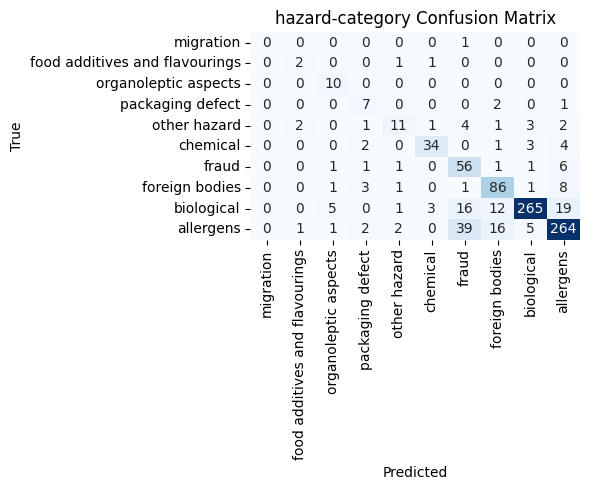

	Evaluation Result -- Accuracy: 0.8050 | Precision: 0.8365 | Recall: 0.8050 | F1: 0.8128
--------------------------------------------------

PRODUCT-CATEGORY


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

prediction: 100%|██████████| 58/58 [00:00<00:00, 95.24it/s]


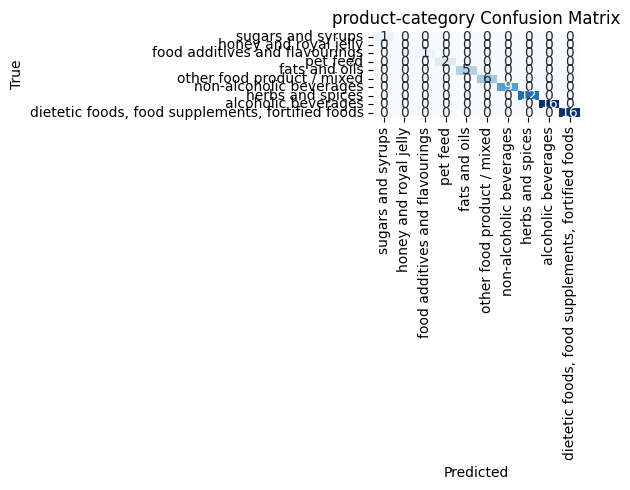

	Evaluation Result -- Accuracy: 0.7547 | Precision: 0.7823 | Recall: 0.7547 | F1: 0.7607
--------------------------------------------------

PRODUCT


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

prediction: 100%|██████████| 58/58 [00:00<00:00, 96.24it/s]


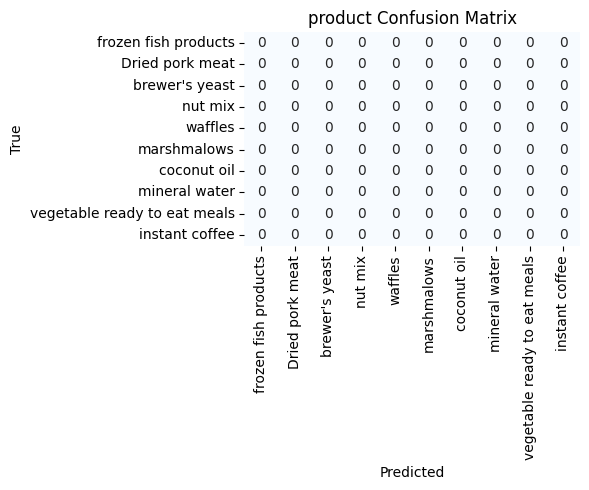

	Evaluation Result -- Accuracy: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
--------------------------------------------------

HAZARD


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

prediction: 100%|██████████| 58/58 [00:00<00:00, 95.32it/s]


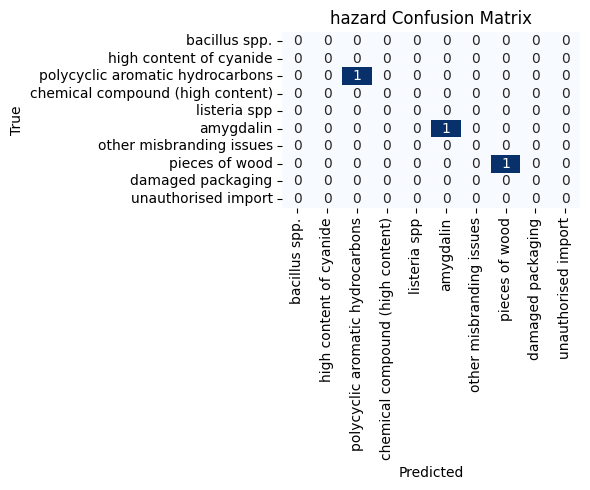

	Evaluation Result -- Accuracy: 0.5433 | Precision: 0.6387 | Recall: 0.5433 | F1: 0.5570
--------------------------------------------------

------ Test Performance Results -------
Score Sub-Task 1: 0.658
Score Sub-Task 2: 0.219


In [18]:
model_folder_name = 'Models'

tokenizer_save_path = os.path.join(root_path, model_folder_name, f'{model_name}_tokenizer')
if model_name == "roberta-base":
    tokenizer = RobertaTokenizer.from_pretrained(tokenizer_save_path)
else:
    raise ValueError(f"The {model_name} is not supported!")

test_true = {}
test_pred = {}
for label_column in labels:
    print(f'\n{label_column.upper()}')
    # Load model
    model_save_path = os.path.join(root_path, model_folder_name, f'{model_name}_{label_column}')

    # Dynamically create the model variable name
    model_variable_name = f"model_{label_column.replace('-', '_')}"
    exec(f"{model_variable_name} = RobertaForSequenceClassification.from_pretrained(model_save_path)")

    # Get the dynamically created model
    model = eval(model_variable_name)

    if verbose > 2:
        print(model)

    # Load label encoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load(os.path.join(model_save_path, 'label_encoder.npy'),allow_pickle=True)

    test_dataloader = generate_dataloader(testset, label_column, label_encoder, tokenizer, train_flag=False)

    test_pred[label_column], test_true[label_column] = predict(model, test_dataloader)

    # Calculate metrics
    accuracy = accuracy_score(test_true[label_column] , test_pred[label_column])
    precision, recall, f1, _ = precision_recall_fscore_support(test_true[label_column] , test_pred[label_column], average='weighted',zero_division=0)

    # Convert predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(test_pred[label_column])
    true_labels = label_encoder.inverse_transform(test_true[label_column] )

    plot_least_frequent_confusion_matrix(true_labels, predicted_labels, label_count=10, title=label_column + ' Confusion Matrix')
    
    if verbose > 0:
        # Print results
        print(f'\tEvaluation Result -- Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')

    if verbose > 1:
        print("\tClassification Report:")
        print(classification_report(true_labels, predicted_labels, zero_division=0))

    print('-'*50)

ST1_score = compute_score(np.array(test_true['hazard-category']), np.array(test_true['product-category']),
                        np.array(test_pred['hazard-category']), np.array(test_pred['product-category']))
ST2_score = compute_score(np.array(test_true['hazard']), np.array(test_true['product']),
                        np.array(test_pred['hazard']), np.array(test_pred['product']))
print("")
print(f"------ Test Performance Results -------")
print(f"Score Sub-Task 1: {ST1_score:.3f}")
print(f"Score Sub-Task 2: {ST2_score:.3f}")
